# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/MCs/'

os.system("mkdir -p "+ plotDir)

0

# ALL BKG TAG EFF

In [3]:
tags = []
tags = [

        '2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
        '2016 QCD_HT_all, background',
        '2016 WLNu_HT_all, background',
        '2016 ZNunu_HT_all, background',
        '2016 TT_Lep, background',

    
        '2017 H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
        '2017 QCD_HT_all, background',
        '2017 WLNu_HT_all, background',
        '2017 ZNunu_HT_all, background',
        '2017 TT_Lep, background',


        '2018 H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
        '2018 QCD_HT_all, background',
        '2018 WLNu_HT_all, background',
        '2018 ZNunu_HT_all, background',
        '2018 TT_Lep, background',


]



# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

fnames['2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v4/MC_Summer16/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['2016 QCD_HT_all, background'] = 'V1p17/v4/MC_Summer16/normalized/QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['2016 WLNu_HT_all, background'] = 'V1p17/v4/MC_Summer16/normalized/WJetsToLNu_HT-70ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['2016 ZNunu_HT_all, background'] = 'V1p17/v4/MC_Summer16/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['2016 TT_Lep, background'] = 'V1p17/v4/MC_Summer16/normalized/TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

fnames['2017 H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v5/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['2017 QCD_HT_all, background'] = 'V1p17/v5/MC_Fall17/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['2017 WLNu_HT_all, background'] = 'V1p17/v5/MC_Fall17/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['2017 ZNunu_HT_all, background'] = 'V1p17/v5/MC_Fall17/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['2017 TT_Lep, background'] = 'V1p17/v5/MC_Fall17/normalized/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

fnames['2018 H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v5/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['2018 QCD_HT_all, background'] = 'V1p17/v5/MC_Fall18/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['2018 WLNu_HT_all, background'] = 'V1p17/v5/MC_Fall18/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['2018 ZNunu_HT_all, background'] = 'V1p17/v5/MC_Fall18/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['2018 TT_Lep, background'] = 'V1p17/v5/MC_Fall18/normalized/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v4/MC_Summer16/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7f58b4f180b8> OrderedDict([('2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7f58b4f180b8>)])
[[0.3811219 0.043495677 0.05918682 0.4142442] [0.014636423] [0.38804093 0.27342394 0.0 0.02618078 0.031228911 0.5336337] ... [0.0 0.4056679] [0.7810731 0.0 0.54346925] [0.016146922 0.115063936]]
[8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06
 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06]
[8.41607e-06]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v4/MC_Summer16/normalized/QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root
Open ready
2016 QCD_HT_all, background
Tree ready
<TTree b'SusyLLPTree' at 0x7f58b4cf0588> OrderedDict([('2016 H(bb)H(bb), 200 

# Test/Debug Plot

In [4]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
    if 'Data' not in k:
#     if 'background' in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
        

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f58b4f180b8>
(3511,)
3008
3008
2016 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f58b4cf0588>


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


(380887,)
262945
262945
2016 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a67d3fd0>
(7823141,)
3255459
3255459
2016 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a65dfc18>
(8214308,)
7872020
7872020
2016 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5783e17eb8>
(17035164,)
6314802
6314802
2017 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f57831d40f0>
(3581,)
3009
3009
2017 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f577ababe10>
(545919,)
374896
374896
2017 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782d1a320>
(16334925,)
6183892
6183892
2017 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782af60f0>
(8009048,)
7611853
7611853
2017 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5781dbb0b8>
(11881734,)
3896019
3896019
2018 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f577d6d8128>
(3581,)
3009
3009
2018 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f57816a0e10>
(497869,)
340805
340805
2018 WLNu_HT_all, bac

In [5]:
 
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/'+'goodlumi_puw_0lep_sig_eb_t-1/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200609/'+'goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/2017/'+'goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/MCs/'+'puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   

 
print(plotDir)
os.system("mkdir -p "+ plotDir)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/MCs/puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/


0

In [5]:
years = ['2016', '2017', '2018']
new_tags = [

        'H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
        'QCD_HT_all, background',
        'WLNu_HT_all, background',
        'ZNunu_HT_all, background',
        'TT_Lep, background',

]


In [6]:


# trg_sum_mdphi = {}
# trg_sum_ht = {}
# trg_sum_met = {} 
# trg_sum_nj = {}

# trg_sum_time = {}
# trg_sum_dr = {}
# trg_sum_tmf = {}
# trg_sum_pt = {}
# trg_sum_eta = {}
# trg_sum_phi = {}
# trg_sum_e = {}
# trg_sum_muef = {}
# trg_sum_eleef = {}
# trg_sum_phoef = {}
# trg_sum_chef = {}
# trg_sum_csv = {}

trg_sum_w = {}
trg_sum_puw = {}

trg_sum_W = {}
     
     


    
for new_tag in new_tags:
    print('TAG', new_tag)
    
#     trg_sum_mdphi[new_tag] = []
#     trg_sum_ht[new_tag] = []
#     trg_sum_met[new_tag] = []
#     trg_sum_nj[new_tag] = []
#     trg_sum_time[new_tag] = []
#     trg_sum_dr[new_tag] = []
#     trg_sum_tmf[new_tag] = []
#     trg_sum_pt[new_tag] = []
#     trg_sum_e[new_tag] = []
#     trg_sum_eta[new_tag] = []
#     trg_sum_phi[new_tag] = []
#     trg_sum_eleef[new_tag] = []
#     trg_sum_muef[new_tag] = []
#     trg_sum_phoef[new_tag] = []
#     trg_sum_chef[new_tag] = []
#     trg_sum_csv[new_tag] = []
    trg_sum_w[new_tag] = []
    trg_sum_puw[new_tag] = []
    trg_sum_W[new_tag] = []

    for k,v in tree.items():
        print(k,v)
        
        if new_tag in k:
#             print('FOUND', new_tag)

#             trg_sum_mdphi[new_tag] = np.concatenate((trg_sum_mdphi[new_tag], trg_jet_mdphi[k]), axis=0, out=None)
#             trg_sum_ht[new_tag] = np.concatenate((trg_sum_ht[new_tag], trg_jet_ht[k]), axis=0, out=None)
#             trg_sum_met[new_tag] = np.concatenate((trg_sum_met[new_tag], trg_jet_met[k]), axis=0, out=None)
#             trg_sum_nj[new_tag] = np.concatenate((trg_sum_nj[new_tag], trg_jet_nj[k]), axis=0, out=None)
            
#             trg_sum_time[new_tag] = np.concatenate((trg_sum_time[new_tag], trg_jet_time[k]), axis=0, out=None)
#             trg_sum_dr[new_tag] = np.concatenate((trg_sum_dr[new_tag], trg_jet_dr[k]), axis=0, out=None)
#             trg_sum_tmf[new_tag] = np.concatenate((trg_sum_tmf[new_tag], trg_jet_tmf[k]), axis=0, out=None)
            
#             trg_sum_pt[new_tag] = np.concatenate((trg_sum_pt[new_tag], trg_jet_pt[k]), axis=0, out=None)
#             trg_sum_e[new_tag] = np.concatenate((trg_sum_e[new_tag], trg_jet_e[k]), axis=0, out=None)
#             trg_sum_eta[new_tag] = np.concatenate((trg_sum_eta[new_tag], trg_jet_eta[k]), axis=0, out=None)
#             trg_sum_phi[new_tag] = np.concatenate((trg_sum_phi[new_tag], trg_jet_phi[k]), axis=0, out=None)
            
#             trg_sum_eleef[new_tag] = np.concatenate((trg_sum_eleef[new_tag], trg_jet_eleef[k]), axis=0, out=None)
#             trg_sum_muef[new_tag] = np.concatenate((trg_sum_muef[new_tag], trg_jet_muef[k]), axis=0, out=None)
#             trg_sum_phoef[new_tag] = np.concatenate((trg_sum_phoef[new_tag], trg_jet_phoef[k]), axis=0, out=None)
#             trg_sum_chef[new_tag] = np.concatenate((trg_sum_chef[new_tag], trg_jet_chef[k]), axis=0, out=None)
#             trg_sum_csv[new_tag] = np.concatenate((trg_sum_csv[new_tag], trg_jet_csv[k]), axis=0, out=None)
            
            if '2016' in k:
                lumi=35922
            elif '2017' in k:
                lumi=41529
            elif '2018' in k:
                lumi=59740
                
            trg_sum_w[new_tag] = np.concatenate((trg_sum_w[new_tag], trg_jet_w[k]*lumi), axis=0, out=None)
            trg_sum_puw[new_tag] = np.concatenate((trg_sum_puw[new_tag], trg_jet_puw[k]), axis=0, out=None)


#             print(len(trg_sum_mdphi[new_tag]))
            print(len(trg_sum_w[new_tag]))
            print(len(trg_sum_puw[new_tag]))

    trg_sum_W[new_tag] = np.array([x*y for x,y in zip(trg_sum_w[new_tag],trg_sum_puw[new_tag])])
    
    print('TAG', new_tag)
    print(len(trg_sum_w[new_tag]))
    print(len(trg_sum_puw[new_tag]))
    print(len(trg_sum_W[new_tag]))



TAG H(bb)H(bb), 200 GeV, 1 GeV, 1 m
2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f58b4f180b8>
3008
3008
2016 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f58b4cf0588>
2016 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a67d3fd0>
2016 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a65dfc18>
2016 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5783e17eb8>
2017 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f57831d40f0>
6017
6017
2017 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f577ababe10>
2017 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782d1a320>
2017 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782af60f0>
2017 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5781dbb0b8>
2018 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f577d6d8128>
9026
9026
2018 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f57816a0e10>
2018 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f57815ff390>
2018 ZNunu_

In [58]:
variables = [
 
    
        ['minDeltaPhi', trg_sum_mdphi, 50, 0, 3.15],
        ['HT', trg_sum_ht, 40, 0, 2000],
        ['MET', trg_sum_met, 20, 0, 2000],
        ['nJets', trg_sum_nj, 20, 0, 20],
    

    
]

var/x_axis minDeltaPhi binning 50 0 3.15
QCD_HT_all, background 978646
WLNu_HT_all, background 12639854
TT_Lep, background 15269666
ZNunu_HT_all, background 23425580
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.01720289944772719
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
137.0 fb^{-1} (13 TeV)
var/x_axis HT binning 40 0 2000
QCD_HT_all, background 978646
WLNu_HT_all, background 12639854
TT_Lep, background 15269666
ZNunu_HT_all, background 23425580
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 1.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
137.0 fb^{-1} (13 TeV)
var/x_axis MET binning 20 0 2000
QCD_HT_all, background 978646
WLNu_HT_all, background 12639854
TT_Lep, background 15269666
ZNunu_HT_all, background 23425580
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 1.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
137.0 fb^{-1} (13 TeV)
var/x_axis nJets binning 20 0 20
QCD_HT_all, background 978646
WLNu_HT_all, b

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: QCD_HT_all, background (50, 0.000000, 3.150000)
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: WLN

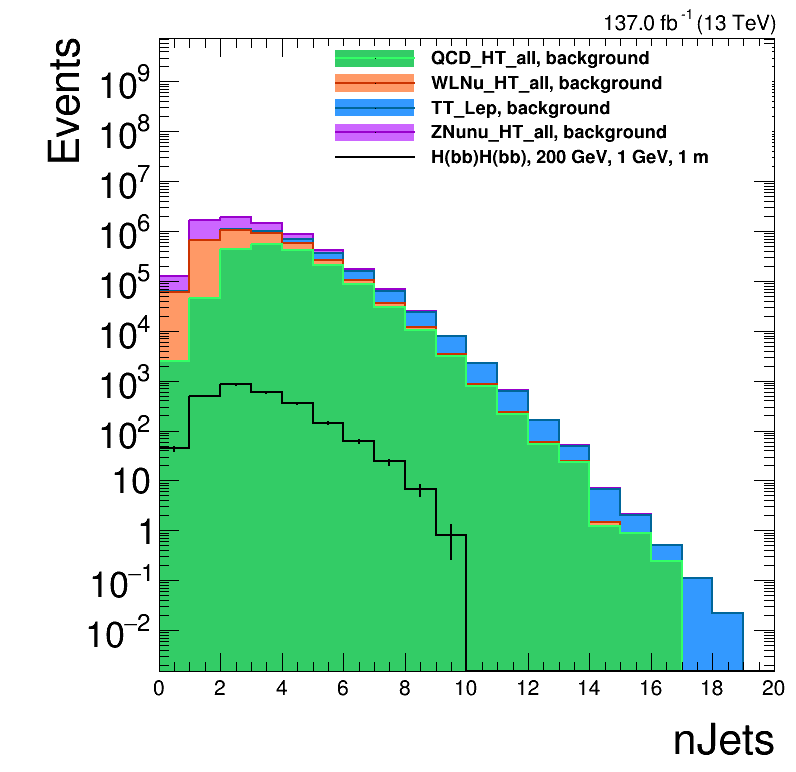

In [60]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 137000 
#     outf = var[0]+'_stack.png'
    
    # Plotting THStack
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
#     pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
#     pad1.SetBottomMargin(0.03)
#     # pad1.SetGridx()
#     pad1.SetLogy()
#     pad1.SetLeftMargin(0.2)
#     pad1.SetRightMargin(0.027)
#     pad1.Draw()
#     pad1.cd()
    
    stack = rt.THStack( "hs" , "H Stack " )
    total = rt.TH1D('total','total',3,0,3)
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
    keys = ['QCD_HT_all, background', 'WLNu_HT_all, background',  'TT_Lep, background', 'ZNunu_HT_all, background',]
#     keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#     sig_keys = []
    sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
    data_keys = [ ]
    # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
    bkg_integral = 0.0
    max_value = 0
    i=0
    for k in keys:
        if 'background' in k or True:


            pt1 = var[1][k] 
            v = pt1 
            w = trg_sum_W[k] 
            if 'QCD' in k:
                sf=1.1
                outf = var[0]+'_stack_sf_'+str(sf).replace('.','p')+'.png'   
            else:
                sf=1
            print(k,len(v))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*sf)
            ht[k].Sumw2()
            total.Add(ht[k])
            stack.Add( ht[k])
            ht[k].SetLineColor(color_list[i]+3)
            ht[k].SetFillColor(color_list[i])
            leg.AddEntry(ht[k],k)
            max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
            bkg_integral += ht[k].Integral()

            i+=1
    stack.Draw('hist')
    # stack.SetMaximum(max_value*1.5)
    stack.SetMaximum(max_value*1e+03)
    stack.SetMinimum(10e-3)
    stack.GetYaxis().SetTitle(y_axis)
    stack.GetXaxis().SetTitle(x_axis)
    stack.GetXaxis().SetLabelSize(0.03)



    i=0
    for k in sig_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_sum_W[k] 

        factor = bkg_integral/np.sum(w)
        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)
        max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

        i+=1

    i=0
    for k in data_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_jet_w[k] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        ht[k].SetMarkerColor(std_color_list[i])
        ht[k].SetMarkerStyle(20)
        ht[k].SetMarkerSize(1.)
        print(k, std_color_list[i])
        ht[k].Draw("p E same")
        leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

        i+=1

    leg.Draw()

#     last = stack.GetStack().Last()
#     total.SetFillStyle(3001)
#     total.SetLineColor(1)
#     total.SetFillColor(1)

#     total.GetYaxis().SetTitleOffset(1.6)
#     total.Draw("same e2")
#     print("total",total.GetBinContent(1),total.GetBinError(1))
    
#     c.cd()
#     pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
#     pad2.SetTopMargin(0.03)
#     pad2.SetBottomMargin(0.25)
#     # pad2.SetGrid()
#     pad2.SetLeftMargin(0.2)
#     pad2.SetRightMargin(0.027)
#     pad2.Draw()
#     pad2.cd()

#     h_copy = ht['Data 2017'].Clone()
#     h_copy.Divide(stack.GetStack().Last())
#     h_copy.GetYaxis().SetTitleOffset(0.4)
# #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
#     h_copy.GetYaxis().SetTitleSize(0.12)
#     h_copy.GetYaxis().SetLabelSize(0.12)
#     h_copy.GetYaxis().SetNdivisions(506)
#     h_copy.SetMaximum(3)
# #     h_copy.SetMaximum(1)
# #     h_copy.SetMaximum(0.5)
# #     h_copy.SetMinimum(-1)
#     h_copy.SetMinimum(0)



#     h_copy.GetXaxis().SetTitleOffset(1)
#     h_copy.GetXaxis().SetTitleSize(0.12)
#     h_copy.GetXaxis().SetLabelSize(0.10)
#     h_copy.GetXaxis().SetTickSize(0.07)
#     h_copy.SetYTitle('Data/MC')
#     h_copy.SetTitle("")
# #        h.SetStats(0)
#     h_copy.DrawCopy('E1')
#     pad2.Update()
    
    


#     c = make_ratio_plot([total,ht['Data 2016']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])


    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

In [78]:
variables = [

#         ['jetTime', trg_sum_time, 50, -13, 13],
    
        ['jetTime', trg_sum_time, 50, -3, 13],
#         ['jetMinDeltaRPVTracks', trg_sum_dr, 50, 0, 3],
#         ['jetTMF', trg_sum_tmf, 50, 0, 1],
    
    
#         ['jetPt', trg_sum_pt, 20, 0, 2000],
#         ['jetEta', trg_sum_eta, 20, -3.15, 3.15],
#         ['jetE', trg_sum_e, 50, 0, 1000],
#         ['jetPhi', trg_sum_phi, 20, -3.15, 3.15],
    
     
#         ['jetMuonEnergyFraction', trg_sum_muef, 50, 0, 1],
#         ['jetElectronEnergyFraction', trg_sum_eleef, 50, 0, 1],
#         ['jetPhotonEnergyFraction', trg_sum_phoef, 50, 0, 1],
    
#         ['jetChargedHadronEnergyFraction', trg_sum_chef, 50, 0, 1],
    
#         ['jetCSV', trg_sum_csv, 50, 0, 1],
 
    
]

0
var/x_axis jetTime binning 50 -3 13
[array([-0.4492768 , -0.51085156,  0.17137192], dtype=float32)
 array([-0.19434303], dtype=float32)
 array([0.08642257, 0.03867019], dtype=float32)
 array([-0.30147994,  0.31732884, -0.6784145 ], dtype=float32)
 array([-0.19607617, -0.97245216], dtype=float32)
 array([-0.28369313, -0.09981937], dtype=float32)
 array([0.35038453, 0.43202078], dtype=float32)
 array([-0.29049018, -0.2425996 , -0.13647524], dtype=float32)
 array([0.12533943], dtype=float32)
 array([0.12115687, 0.01062811], dtype=float32)]
[3 1 2 3 2 2 2 3 1 2]
969154
QCD_HT_all, background 969154 969154
[array([], dtype=float32) array([], dtype=float32)
 array([-0.24245912,  0.38066083], dtype=float32)
 array([0.3218062], dtype=float32)
 array([-0.18257092,  0.21080638], dtype=float32) array([], dtype=float32)
 array([], dtype=float32) array([-0.00558874], dtype=float32)
 array([-0.24187028], dtype=float32) array([], dtype=float32)]
[0 0 2 1 2 0 0 1 1 0]
12113452
WLNu_HT_all, backgroun

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: QCD_HT_all, background (50, -3.000000, 13.000000)
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: W

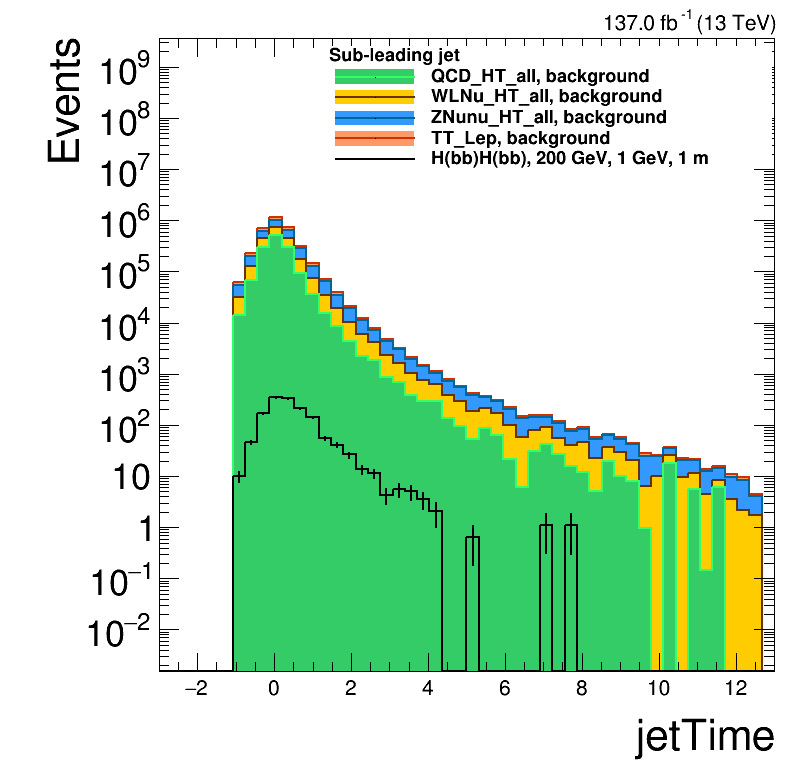

In [79]:
for cnt in range(2):
    print(cnt)
    part = cnt
    if cnt==0:
        cnt_str = 'Leading jet'
        name_str = 'leading_jet'
    else:
        cnt_str = 'Sub-leading jet'
        name_str = 'sub_leading_jet'
    for var in variables:
        print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
        x_axis = var[0]
        y_axis = 'Events'
        axis_set = [x_axis, y_axis]
        bin_set = [var[2],var[3],var[4]]
        lumi = 137000
#         outf = var[0]+'_'+name_str+'_stack_pt100.png'
        outf = var[0]+'_'+name_str+'_stack.png'

        # Plotting THStack
        c = rt.TCanvas('c','c', 800, 800)
        ht = {}
        # leg = rt.TLegend(0.59,0.70,0.97,0.93)
        leg = rt.TLegend(0.40,0.78,0.97,0.94)

        leg.SetTextSize(0.025)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
    
#         pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
#         pad1.SetBottomMargin(0.03)
#         # pad1.SetGridx()
#         pad1.SetLogy()
#         pad1.SetLeftMargin(0.2)
#         pad1.SetRightMargin(0.027)
#         pad1.Draw()
#         pad1.cd()
    
        stack = rt.THStack( "hs" , "H Stack " )
        total = rt.TH1D('total','total',3,0,3)
        color_list = [845,800,861,806,876,597,625]
        keys=[]
        keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
        sig_keys = [  ]
        sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
        data_keys = []
#         data_keys = ['Data 2017']
        # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
        bkg_integral = 0.0
        max_value = 0
        i=0
        for k in keys:
            if 'background' in k or True:


                pt1 = np.array(var[1][k]) 
#                 print(pt1[:10])
                pt3=np.array([len(x) for x in pt1])
#                 print(pt3[:10])
                pt2 = np.array(pt1[pt3>part])
                print(len(pt2))
                v = np.array([x[part] for x in pt2])
                w = trg_sum_W[k][pt3>part] 
                print(k,len(v),len(w))
                if 'QCD' in k:
                    sf=1.1
                else:
                    sf=1
                ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*sf)
                ht[k].Sumw2()
                total.Add(ht[k])
                stack.Add( ht[k])
                ht[k].SetLineColor(color_list[i]+3)
                ht[k].SetFillColor(color_list[i])
                leg.AddEntry(ht[k],k)
                max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
                bkg_integral += ht[k].Integral()

                i+=1
        stack.Draw('hist')
        # stack.SetMaximum(max_value*1.5)
        stack.SetMaximum(max_value*1e+03)
        stack.SetMinimum(10e-3)
        stack.GetYaxis().SetTitle(y_axis)
        stack.GetXaxis().SetTitle(x_axis)
        stack.GetXaxis().SetLabelSize(0.03)



        i=0
        for k in sig_keys:
            pt1 = var[1][k] 
            pt3=np.array([len(x) for x in pt1])
            pt2 = pt1[pt3>part]
            print(len(pt2))
            v = np.array([x[part] for x in pt2])
            w = trg_sum_W[k][pt3>part] 

            factor = bkg_integral/np.sum(w)
            print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            print(k, std_color_list[i])
            ht[k].Draw("hist E same")
            leg.AddEntry(ht[k],k)
            max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
            print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

            i+=1

        i=0
        for k in data_keys:
            pt1 = var[1][k] 
            pt2 = pt1[pt1.count()>part]
            print(len(pt2))
            v = pt2[:,part]
            w = trg_sum_W[k][pt1.count()>part] 

            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            ht[k].SetMarkerColor(std_color_list[i])
            ht[k].SetMarkerStyle(20)
            ht[k].SetMarkerSize(1.)
            print(k, std_color_list[i])
            ht[k].Draw("p E same")
            leg.AddEntry(ht[k],k+str(lumi/1000)+' /fb')

            i+=1

        leg.SetHeader(cnt_str)
        leg.Draw()

#         last = stack.GetStack().Last()
#         total.SetFillStyle(3001)
#         total.SetLineColor(1)
#         total.SetFillColor(1)

#         total.GetYaxis().SetTitleOffset(1.6)
#         total.Draw("same e2")
#         print("total",total.GetBinContent(1),total.GetBinError(1))

#         c.cd()
#         pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
#         pad2.SetTopMargin(0.03)
#         pad2.SetBottomMargin(0.25)
#         # pad2.SetGrid()
#         pad2.SetLeftMargin(0.2)
#         pad2.SetRightMargin(0.027)
#         pad2.Draw()
#         pad2.cd()

#         h_copy = ht['Data 2017'].Clone()
#         h_copy.Divide(stack.GetStack().Last())
#         h_copy.GetYaxis().SetTitleOffset(0.4)
#     #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
#         h_copy.GetYaxis().SetTitleSize(0.12)
#         h_copy.GetYaxis().SetLabelSize(0.12)
#         h_copy.GetYaxis().SetNdivisions(506)
#         h_copy.SetMaximum(3)
#         h_copy.SetMinimum(0)



#         h_copy.GetXaxis().SetTitleOffset(1)
#         h_copy.GetXaxis().SetTitleSize(0.12)
#         h_copy.GetXaxis().SetLabelSize(0.10)
#         h_copy.GetXaxis().SetTickSize(0.07)
#         h_copy.SetYTitle('Data/MC')
#         h_copy.SetTitle("")
#     #        h.SetStats(0)
#         h_copy.DrawCopy('E1')
#         pad2.Update()
    



        CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
        CMS_lumi.cmsText = ""
        CMS_lumi.writeExtraText = False
        CMS_lumi.CMS_lumi(c,4,3)


        c.SetLeftMargin(0.2)
        c.SetRightMargin(0.027)
        c.SetLogy()
        c.Draw()
        c.SaveAs(plotDir+outf)


# Tags

In [7]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 


nTags = {}     


    
 
    
for k,v in tree.items():
    print(k,v)

    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 

    nTags[k] = trg_jet_pt[k][tagged_jet].count()
        
#     for i,ele in enumerate(nTags[k]):
#         if ele > 2:
#             nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
     


2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f58b4f180b8>
[0 1 2 3]
2016 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f58b4cf0588>
[0 1]
2016 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a67d3fd0>
[0 1 2]
2016 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a65dfc18>
[0 1 2]
2016 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5783e17eb8>
[0 1 2]
2017 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f57831d40f0>
[0 1 2 3]
2017 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f577ababe10>
[0 1]
2017 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782d1a320>
[0 1 2]
2017 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782af60f0>
[0 1 2]
2017 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5781dbb0b8>
[0 1 2]
2018 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f577d6d8128>
[0 1 2 3]
2018 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f57816a0e10>
[0 1]
2018 WLNu_HT_all, background <TTree b'SusyLLPTree' 

In [10]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'All Jet Yield', 'All Jet Error',  'Tag Yield', 'Tag Error', 'Tag Eff'])
for k,v in tree.items():
 
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
    JetW = [x*y for x,y in zip(EventW, trg_jet_pt[k].count())]
    TagW = [x*y for x,y in zip(EventW, nTags[k])]
    EventWsq = [x*x  for x in  EventW]
    JetWsq = [x*x*y*y  for x,y in zip(EventW, trg_jet_pt[k].count())]
    TagWsq = [x*x*y*y  for x,y in zip(EventW, nTags[k])]
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(JetW)*lumi, 2), round(math.sqrt(np.sum(JetWsq))*lumi, 2), round(np.sum(TagW)*lumi, 2), round(math.sqrt(np.sum(TagWsq))*lumi, 2), round(np.sum(TagW)/np.sum(JetW), 10) ]
    table.add_row(row)
        
print(table)    



======================= Summary ==============================


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


+--------------------------------------+------------------------------------------------------------------------+---------------+---------------+-----------+-----------+--------------+
|                Sample                |                                 Weight                                 | All Jet Yield | All Jet Error | Tag Yield | Tag Error |   Tag Eff    |
+--------------------------------------+------------------------------------------------------------------------+---------------+---------------+-----------+-----------+--------------+
| 2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m |                             [8.41607e-06]                              |      0.0      |      0.0      |    0.0    |    0.0    |     nan      |
|     2016 QCD_HT_all, background      | [4.2196252e-06 1.0127245e-05 7.9350793e-05 1.5036011e-04 5.0976203e-04 |   3487494.29  |    17831.65   |  1579.28  |   221.0   | 0.0004528395 |
|                                      |                             6.3758

In [12]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Per Jet Tag Eff'])
for k,v in tree.items():
 
    if 'GeV' not in k:
        lumi=137000
        EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
        JetW = [x*y for x,y in zip(EventW, trg_jet_pt[k].count())]
        TagW = [x*y for x,y in zip(EventW, nTags[k])]
        EventWsq = [x*x  for x in  EventW]
        JetWsq = [x*x*y*y  for x,y in zip(EventW, trg_jet_pt[k].count())]
        TagWsq = [x*x*y*y  for x,y in zip(EventW, nTags[k])]
    #     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
        row = [k,  round(np.sum(TagW)/np.sum(JetW), 10) ]
        table.add_row(row)
        
print(table)    



======================= Summary ==============================
+-------------------------------+-----------------+
|             Sample            | Per Jet Tag Eff |
+-------------------------------+-----------------+
|  2016 QCD_HT_all, background  |   0.0004528395  |
|  2016 WLNu_HT_all, background |   0.0006538637  |
| 2016 ZNunu_HT_all, background |   0.0003707806  |
|    2016 TT_Lep, background    |   0.0005309626  |
|  2017 QCD_HT_all, background  |   0.0007362653  |
|  2017 WLNu_HT_all, background |   0.0008272239  |
| 2017 ZNunu_HT_all, background |   0.0005038176  |
|    2017 TT_Lep, background    |   0.0006559646  |
|  2018 QCD_HT_all, background  |   0.0005733825  |
|  2018 WLNu_HT_all, background |   0.0008263627  |
| 2018 ZNunu_HT_all, background |   0.0005313531  |
|    2018 TT_Lep, background    |   0.0006831639  |
+-------------------------------+-----------------+


In [8]:


trg_sum_nTags = {}     


    
for new_tag in new_tags:
    print('TAG', new_tag)
    
 
    trg_sum_nTags[new_tag] = []

    for k,v in tree.items():
        print(k,v)
        
        #tag cuts
        
        if new_tag in k:
#             print('FOUND', new_tag)

            trg_sum_nTags[new_tag] = np.concatenate((trg_sum_nTags[new_tag], nTags[k]), axis=0, out=None)
    
 
    
    print('TAG', new_tag)
    print(len(trg_sum_w[new_tag]))
    print(len(trg_sum_puw[new_tag]))
    print(len(trg_sum_W[new_tag]))
    print(len(trg_sum_nTags[new_tag]))



TAG H(bb)H(bb), 200 GeV, 1 GeV, 1 m
2016 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f58b4f180b8>
2016 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f58b4cf0588>
2016 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a67d3fd0>
2016 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f58a65dfc18>
2016 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5783e17eb8>
2017 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f57831d40f0>
2017 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f577ababe10>
2017 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782d1a320>
2017 ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7f5782af60f0>
2017 TT_Lep, background <TTree b'SusyLLPTree' at 0x7f5781dbb0b8>
2018 H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f577d6d8128>
2018 QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f57816a0e10>
2018 WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f57815ff390>
2018 ZNunu_HT_all, background <TTree b'Su

In [12]:
variables = [
 
        ['nTags', trg_sum_nTags, 3, 0, 3],
    
]

var/x_axis nTags binning 3 0 3
QCD_HT_all, background 978646
WLNu_HT_all, background 12639854
TT_Lep, background 15269666
ZNunu_HT_all, background 23425580
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 256 113.15323097572724
137.0 fb^{-1} (13 TeV)


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/MCs/puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/nTags_stack_sf_1p1.png has been created


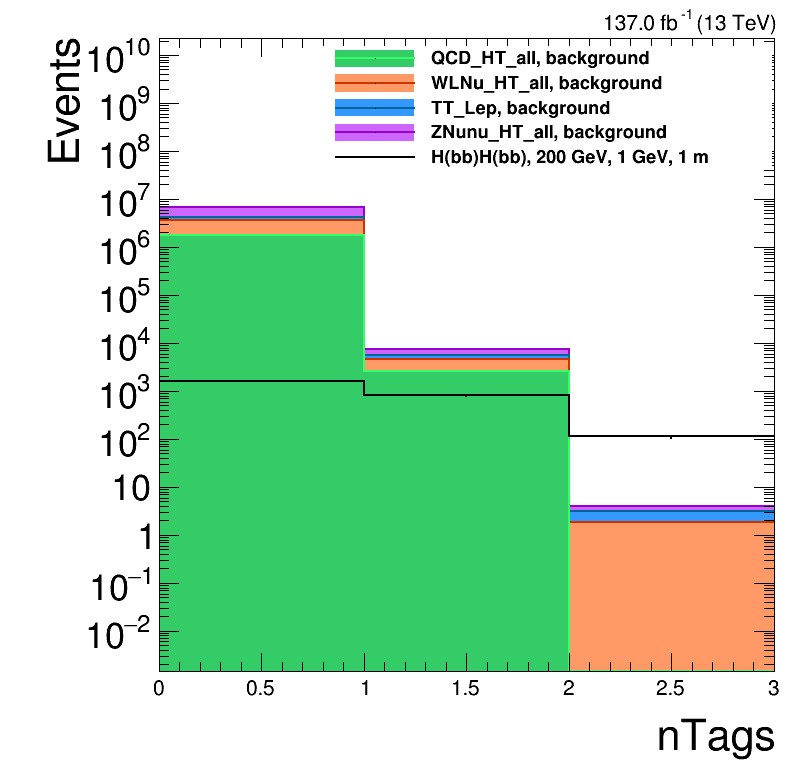

In [13]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 137000 
#     outf = var[0]+'_stack.png'
    
    # Plotting THStack
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
#     pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
#     pad1.SetBottomMargin(0.03)
#     # pad1.SetGridx()
#     pad1.SetLogy()
#     pad1.SetLeftMargin(0.2)
#     pad1.SetRightMargin(0.027)
#     pad1.Draw()
#     pad1.cd()
    
    stack = rt.THStack( "hs" , "H Stack " )
    total = rt.TH1D('total','total',3,0,3)
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
    keys = ['QCD_HT_all, background', 'WLNu_HT_all, background',  'TT_Lep, background', 'ZNunu_HT_all, background',]
#     keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#     sig_keys = []
    sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
#     data_keys = ['Data 2017']
    data_keys = [ ]
    # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
    bkg_integral = 0.0
    max_value = 0
    i=0
    for k in keys:
        if 'background' in k or True:


            pt1 = var[1][k] 
            v = pt1 
            w = trg_sum_W[k] 
            if 'QCD' in k:
                sf=1.1
                outf = var[0]+'_stack_sf_'+str(sf).replace('.','p')+'.png'   
            else:
                sf=1
            print(k,len(v))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*sf)
            ht[k].Sumw2()
            total.Add(ht[k])
            stack.Add( ht[k])
            ht[k].SetLineColor(color_list[i]+3)
            ht[k].SetFillColor(color_list[i])
            leg.AddEntry(ht[k],k)
            max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
            bkg_integral += ht[k].Integral()

            i+=1
    stack.Draw('hist')
    # stack.SetMaximum(max_value*1.5)
    stack.SetMaximum(max_value*1e+03)
    stack.SetMinimum(10e-3)
    stack.GetYaxis().SetTitle(y_axis)
    stack.GetXaxis().SetTitle(x_axis)
    stack.GetXaxis().SetLabelSize(0.03)



    i=0
    for k in sig_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_sum_W[k] 

        factor = bkg_integral/np.sum(w)
        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)
        max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

        i+=1

    i=0
    for k in data_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_jet_w[k] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        ht[k].SetMarkerColor(std_color_list[i])
        ht[k].SetMarkerStyle(20)
        ht[k].SetMarkerSize(1.)
        print(k, std_color_list[i])
        ht[k].Draw("p E same")
        leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

        i+=1

    leg.Draw()

#     last = stack.GetStack().Last()
#     total.SetFillStyle(3001)
#     total.SetLineColor(1)
#     total.SetFillColor(1)

#     total.GetYaxis().SetTitleOffset(1.6)
#     total.Draw("same e2")
#     print("total",total.GetBinContent(1),total.GetBinError(1))
    
#     c.cd()
#     pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
#     pad2.SetTopMargin(0.03)
#     pad2.SetBottomMargin(0.25)
#     # pad2.SetGrid()
#     pad2.SetLeftMargin(0.2)
#     pad2.SetRightMargin(0.027)
#     pad2.Draw()
#     pad2.cd()

#     h_copy = ht['Data 2017'].Clone()
#     h_copy.Divide(stack.GetStack().Last())
#     h_copy.GetYaxis().SetTitleOffset(0.4)
# #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
#     h_copy.GetYaxis().SetTitleSize(0.12)
#     h_copy.GetYaxis().SetLabelSize(0.12)
#     h_copy.GetYaxis().SetNdivisions(506)
#     h_copy.SetMaximum(5)
# #     h_copy.SetMaximum(3)
# #     h_copy.SetMaximum(1)
# #     h_copy.SetMaximum(0.5)
# #     h_copy.SetMinimum(-1)
#     h_copy.SetMinimum(0)



#     h_copy.GetXaxis().SetTitleOffset(1)
#     h_copy.GetXaxis().SetTitleSize(0.12)
#     h_copy.GetXaxis().SetLabelSize(0.10)
#     h_copy.GetXaxis().SetTickSize(0.07)
#     h_copy.SetYTitle('Data/MC')
#     h_copy.SetTitle("")
# #        h.SetStats(0)
#     h_copy.DrawCopy('E1')
#     pad2.Update()
    
    


#     c = make_ratio_plot([total,ht['Data 2016']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])


    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

var/x_axis nTags binning 3 0 3
QCD_HT_all, background 978646
WLNu_HT_all, background 12639854
TT_Lep, background 15269666
ZNunu_HT_all, background 23425580
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 256 113.15323097572724
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/j

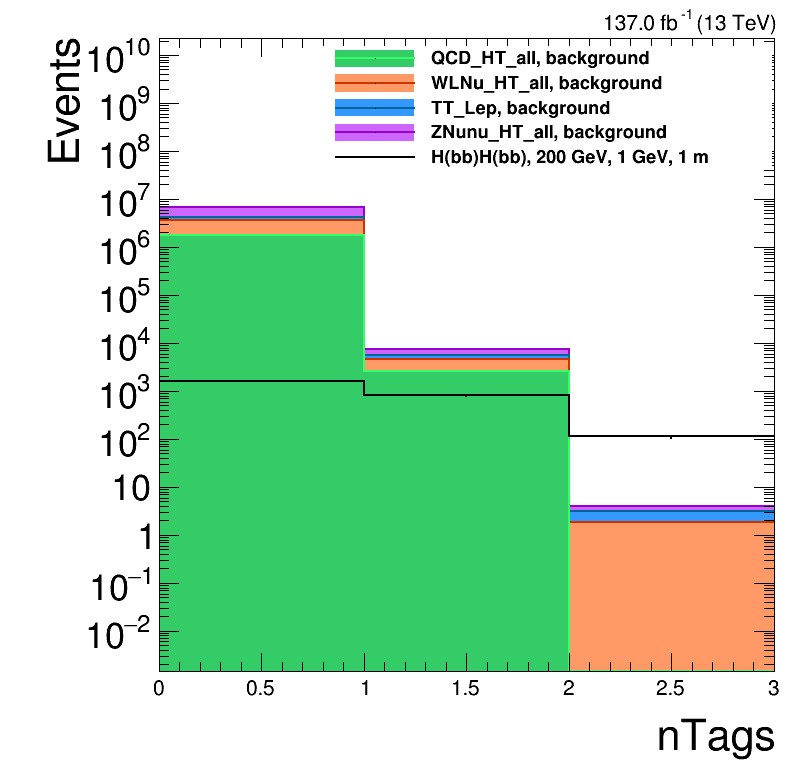

In [14]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 137000 
#     outf = var[0]+'_stack.png'
    
    # Plotting THStack
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
#     pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
#     pad1.SetBottomMargin(0.03)
#     # pad1.SetGridx()
#     pad1.SetLogy()
#     pad1.SetLeftMargin(0.2)
#     pad1.SetRightMargin(0.027)
#     pad1.Draw()
#     pad1.cd()
    
    stack = rt.THStack( "hs" , "H Stack " )
    total = rt.TH1D('total','total',3,0,3)
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
    keys = ['QCD_HT_all, background', 'WLNu_HT_all, background',  'TT_Lep, background', 'ZNunu_HT_all, background',]
#     keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#     sig_keys = []
    sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
#     data_keys = ['Data 2017']
    data_keys = []
    # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
    bkg_integral = 0.0
    max_value = 0
    i=0
    for k in keys:
        if 'background' in k or True:


            pt1 = var[1][k] 
            v = pt1 
            w = trg_sum_W[k] 
            if 'QCD' in k:
                sf=1.1
                outf = var[0]+'_stack_sf_'+str(sf).replace('.','p')+'_blind.png'   
            else:
                sf=1
            print(k,len(v))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*sf)
            ht[k].Sumw2()
            total.Add(ht[k])
            stack.Add( ht[k])
            ht[k].SetLineColor(color_list[i]+3)
            ht[k].SetFillColor(color_list[i])
            leg.AddEntry(ht[k],k)
            max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
            bkg_integral += ht[k].Integral()

            i+=1
    stack.Draw('hist')
    # stack.SetMaximum(max_value*1.5)
    stack.SetMaximum(max_value*1e+03)
    stack.SetMinimum(10e-3)
    stack.GetYaxis().SetTitle(y_axis)
    stack.GetXaxis().SetTitle(x_axis)
    stack.GetXaxis().SetLabelSize(0.03)



    i=0
    for k in sig_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_sum_W[k] 

        factor = bkg_integral/np.sum(w)
        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)
        max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

        i+=1

    i=0
    for k in data_keys:
        pt1 = var[1][k]
        for y,ele in enumerate(pt1):
            if ele==2:
                pt1[y]=3
        v = pt1 
        w = trg_jet_w[k] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        ht[k].SetMarkerColor(std_color_list[i])
        ht[k].SetMarkerStyle(20)
        ht[k].SetMarkerSize(1.)
        print(k, std_color_list[i])
        ht[k].Draw("p E same")
        leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

        i+=1

    leg.Draw()

#     last = stack.GetStack().Last()
#     total.SetFillStyle(3001)
#     total.SetLineColor(1)
#     total.SetFillColor(1)

#     total.GetYaxis().SetTitleOffset(1.6)
#     total.Draw("same e2")
#     print("total",total.GetBinContent(1),total.GetBinError(1))
    
#     c.cd()
#     pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
#     pad2.SetTopMargin(0.03)
#     pad2.SetBottomMargin(0.25)
#     # pad2.SetGrid()
#     pad2.SetLeftMargin(0.2)
#     pad2.SetRightMargin(0.027)
#     pad2.Draw()
#     pad2.cd()

#     h_copy = ht['Data 2017'].Clone()
#     h_copy.Divide(stack.GetStack().Last())
#     h_copy.GetYaxis().SetTitleOffset(0.4)
# #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
#     h_copy.GetYaxis().SetTitleSize(0.12)
#     h_copy.GetYaxis().SetLabelSize(0.12)
#     h_copy.GetYaxis().SetNdivisions(506)
#     h_copy.SetMaximum(5)
# #     h_copy.SetMaximum(3)
# #     h_copy.SetMaximum(1)
# #     h_copy.SetMaximum(0.5)
# #     h_copy.SetMinimum(-1)
#     h_copy.SetMinimum(0)



#     h_copy.GetXaxis().SetTitleOffset(1)
#     h_copy.GetXaxis().SetTitleSize(0.12)
#     h_copy.GetXaxis().SetLabelSize(0.10)
#     h_copy.GetXaxis().SetTickSize(0.07)
#     h_copy.SetYTitle('Data/MC')
#     h_copy.SetTitle("")
# #        h.SetStats(0)
#     h_copy.DrawCopy('E1')
#     pad2.Update()
    
    


#     c = make_ratio_plot([total,ht['Data 2016']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])


    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

# Tag Eff

In [ ]:
from itertools import chain 

wall = {}
wnum = {}

pt_denall = {}
eta_denall = {}
pt_numall = {}
eta_numall = {}

pt_den_all = {}
eta_den_all = {}
pt_num_all = {}
eta_num_all = {}

pt_pEff = {}
eta_pEff = {}

for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    eta_denall[k] = np.array(trg_jet_eta[k].flatten())
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(eta_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    eta_numall[k] =  np.array(tag_jet_eta[k].flatten())
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
#     print(len(trg_jet_w[k]))
#     print(len(tag_jet_pt[k]))
    
    print(len(pt_numall[k]))
    print(len(eta_numall[k]))
#     print(max(eta_numall[k]))
#     print(min(eta_numall[k]))
#     print(eta_numall[k])
#     print(pt_numall[k])
    print(len(wnum[k]))
    
    #histogram
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wnum[k])
    
#     pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[10,-0,100], weights=wall[k])
#     pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[10,-0,100], weights=wnum[k])
    
    eta_den_all[k] = create_TH1D( eta_denall[k], axis_title=['jetEta ', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wall[k])
    eta_num_all[k] = create_TH1D( eta_numall[k], axis_title=['jetEta', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wnum[k])
  
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
    eta_pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
    

In [ ]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.005],
#         ['jetEta', eta_pEff, 'eta', -0.0002, 0.005],
    
]

In [ ]:

   

color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(10):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)
